In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('data/cleaned/airbnb_staged2.csv')

In [4]:
df.host_name.nunique()

5792

In [5]:
df.host_id.nunique()
# There are multiple hosts with the same name. So we will use the host_id 

12382

In [6]:
df.neighbourhood_group.unique()

# Dataset consists of 5 major cities in New York

array(['Brooklyn', 'Manhattan', 'Queens', 'Bronx', 'Staten Island'],
      dtype=object)

#### Creating a new feature: rating_category

In [7]:
df['rating'].dtype

dtype('float64')

In [8]:
df['rating_category'] = pd.cut(df['rating'], bins = (-1, 4, 4.8, 5), labels = ['Low rated','Mid rated','High rated'])
df.rating_category.value_counts()

rating_category
High rated    8549
Mid rated     7787
Low rated      573
Name: count, dtype: int64

#### Creating a new feature: host_category

In [9]:
df['host_category'] = pd.cut(df['calculated_host_listings_count'], bins = (0,2,5,20,714), labels = ['Casual Host','Small Business','Professional Host','Large Business'])

In [10]:
df.host_category.value_counts(normalize=True).mul(100).round(1)

# Casual hosts seems to be dominating

host_category
Casual Host          58.9
Small Business       16.3
Professional Host    13.0
Large Business       11.9
Name: proportion, dtype: float64

#### Creating a new feature: stay_category

In [11]:
df['stay_category'] = pd.cut(df['minimum_nights'], bins =(0, 3, 7, 14, 30, 1251), labels = ['Weekend stay','Week stay','Fortnight','Monthly Stay','Long-term'] )

In [12]:
df.stay_category.value_counts(normalize=True).mul(100).round(1)

# Majority of the listings allow monthly stays (minimum nights ranging 15-30 nights)

stay_category
Monthly Stay    81.5
Weekend stay    12.7
Long-term        4.0
Week stay        1.7
Fortnight        0.0
Name: proportion, dtype: float64

#### Let's take a look at availability of each listings

<Axes: xlabel='availability_365', ylabel='Count'>

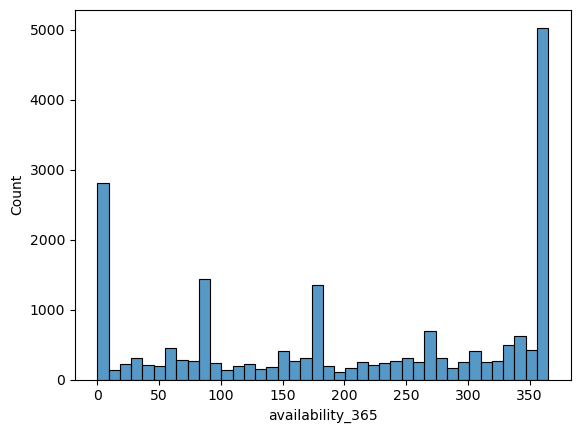

In [13]:
sns.histplot(df, x='availability_365', bins = 40)

In [14]:
figure = px.scatter(
    df, 
    x='price',
    y='availability_365',
    color = 'host_category'
)

figure.show()

# availability and price seems to have no pattern 

#### Searching for any correlation between numerical values 

In [15]:
cols = ['price_per_bedrooms', 'bedrooms','minimum_nights','number_of_reviews','number_of_reviews_ltm','availability_365','rating','calculated_host_listings_count', ]

corr = df[cols].corr()

figure = px.imshow(
    corr, 
    color_continuous_scale = 'Blues', 
    text_auto= '.2f',
    title = 'Correlation heatmap'
)

figure.update_layout(height = 600, width = 800)
figure.show()
print('There seems to be no correlation whatsoever')

There seems to be no correlation whatsoever


#### Looking at the lisitngs where availability is 0 

In [16]:
# New feature: year_last_review. This will help us strengthen the case of whether a listings has been inactive for too long to flag it as inactive

df['last_review_year'] = pd.to_datetime(df['last_review']).dt.year


C:\Users\pc\AppData\Local\Temp\ipykernel_5624\3793742170.py:3: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [17]:

not_available = df[df.availability_365 == 0]
print(f'Total number of not available listings: {len(not_available)}')
print(f'Percentage of not available listings: {len(not_available)/ len(df) * 100:.2f}')

Total number of not available listings: 2473
Percentage of not available listings: 11.98


In [18]:
# number_of_reviews_ltm (last twelve months) tells us the recent demand 

x = not_available[not_available.number_of_reviews_ltm == 0]
print(f'Number of listings that has 0 number of reviews in the last year in availaibility = 0 group: {len(x)}')
print(f'Percentage of listings that has 0 number of reviews in the last year in availaibility = 0 group: {len(x)/len(not_available) * 100:.2f}')

# 0 availability with 0 reviews in the past year may signal that the listing has been blocked by the host rather than low demand.
# 52% of the not available listings may be inactive

Number of listings that has 0 number of reviews in the last year in availaibility = 0 group: 1307
Percentage of listings that has 0 number of reviews in the last year in availaibility = 0 group: 52.85


#### Let's calculate the % of listings with availability = 0 for each host_category

In [19]:
df.groupby('host_category').apply(lambda group: (group['availability_365'] == 0).mean() * 100).round(2)

# We can see that casual hosts are 2x more likely to keep their calendars closed.
# This could be due to personal reasons

C:\Users\pc\AppData\Local\Temp\ipykernel_5624\3439568256.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pc\AppData\Local\Temp\ipykernel_5624\3439568256.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



host_category
Casual Host          15.09
Small Business        7.77
Professional Host     7.85
Large Business        6.88
dtype: float64

#### Flagging listings as inactive if there was no review in the past year, not available at all, and if the last review was atleast 2 years ago.

In [20]:
df.last_review_year.min()

2011

In [21]:
inactive_condition =(
    (df['availability_365'] == 0) &
    (df['number_of_reviews_ltm'] == 0 ) &
    (df['last_review_year'] <= 2021)
)

df.insert(17, 'is_active', ~inactive_condition)

In [22]:
not_active = df[df.is_active == False]
print(f"Number of inactive listings: {len(not_active)}")
print(f"Percentage of inactive listings: {len(not_active) / len(df) * 100:.2f}")

Number of inactive listings: 1137
Percentage of inactive listings: 5.51


In [23]:
not_active.host_category.value_counts(normalize=True).mul(100).round(2)

# Majoity of the inactive listings are from casual hosts

host_category
Casual Host          89.27
Small Business        6.07
Professional Host     3.78
Large Business        0.88
Name: proportion, dtype: float64

In [24]:
df.groupby('host_category').apply(lambda group: (group['is_active']== False).mean() * 100).round(1)

# Casual hosts seems to be showing high inactivity compared to bigger businesses.

C:\Users\pc\AppData\Local\Temp\ipykernel_5624\2188397487.py:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pc\AppData\Local\Temp\ipykernel_5624\2188397487.py:1: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



host_category
Casual Host          8.4
Small Business       2.1
Professional Host    1.6
Large Business       0.4
dtype: float64

#### New feature: reviews_category (high reviewed, mid reviews, low reviews)

In [25]:
df['reviews_category'] = pd.cut(df['number_of_reviews_ltm'], bins = (0,6,31,2000), right = False, labels = ['Low reviews','Mid reviews','High reviews'] )

In [26]:
print(df.reviews_category.value_counts(),'\n')
print(df.reviews_category.value_counts(normalize=True).mul(100).round(1))

reviews_category
Low reviews     12199
Mid reviews      6185
High reviews     2252
Name: count, dtype: int64 

reviews_category
Low reviews     59.1
Mid reviews     30.0
High reviews    10.9
Name: proportion, dtype: float64


#### Let's go deeper into the dataset but before that let's remove all the inactive listings since we are looking for performance analysis here

In [27]:
# Filtering out the inactive listings 

df1 = df[df.is_active]

In [28]:
df1.shape

(19499, 30)

In [29]:
# Let's look at the composition of each neighbourhood groups 

boroughs_total = df1.neighbourhood_group.value_counts(normalize=True).mul(100).round(2)
print(boroughs_total)

# Manhattan and Brooklyn seems to be in high supply

neighbourhood_group
Manhattan        38.49
Brooklyn         37.31
Queens           18.13
Bronx             4.63
Staten Island     1.44
Name: proportion, dtype: float64


In [30]:
# Taking the two extremes (high reviews and low reviews)

low_reviews = df1[df1.reviews_category == 'Low reviews']
high_reviews = df1[df1.reviews_category == 'High reviews']

print(f"Number of Low Reviews listings: {len(low_reviews)}")
print(f"Number of High Reviews listings: {len(high_reviews)}")

Number of Low Reviews listings: 11062
Number of High Reviews listings: 2252


In [31]:
boroughs_total

neighbourhood_group
Manhattan        38.49
Brooklyn         37.31
Queens           18.13
Bronx             4.63
Staten Island     1.44
Name: proportion, dtype: float64

In [36]:
fig = px.bar(
    boroughs_total,
    text_auto = True,
    title = 'Composition of each Borough in the dataset'
)

fig.update_layout(
    height = 400, 
    width = 600
)
fig.show()

In [42]:
# Checking if location has any play when it comes to reviews 

print("Neighbourhood Distribution in the entire dataset")
print(boroughs_total)

fig = px.bar(
    boroughs_total,
    text_auto = True,
    title = 'Composition of each Borough in the dataset'
)

fig.update_layout(
    height = 400, 
    width = 600
)
fig.show()


print("High reviews group")
high_count = high_reviews['neighbourhood_group'].value_counts(normalize=True).mul(100).round(1)
print(high_count)

print("\nLow reviews group")
low_count = low_reviews['neighbourhood_group'].value_counts(normalize=True).mul(100).round(1)
print(low_count)

combined = pd.DataFrame({
    'High Reviews' : high_count, 
    'Low Reviews' : low_count
})

figure = px.bar(combined.reset_index(), x='neighbourhood_group', y = ['High Reviews','Low Reviews'], barmode = 'group', title = 'Nighbourhood Distribution (High & Low Reviews category)', text_auto = True)
figure.update_layout(height = 500, width = 700)
figure.show()

# Despite similar shares throughout the entire dataset. 
# Brooklyn listings seem to account higher for higher reviews and Manhattan listings are seen more among the low reviews group.

Neighbourhood Distribution in the entire dataset
neighbourhood_group
Manhattan        38.49
Brooklyn         37.31
Queens           18.13
Bronx             4.63
Staten Island     1.44
Name: proportion, dtype: float64


High reviews group
neighbourhood_group
Brooklyn         40.2
Manhattan        31.7
Queens           22.2
Bronx             4.0
Staten Island     1.9
Name: proportion, dtype: float64

Low reviews group
neighbourhood_group
Manhattan        45.0
Brooklyn         34.8
Queens           15.1
Bronx             4.1
Staten Island     1.1
Name: proportion, dtype: float64


## Manhattan

#### Observing Manhattan independently

In [82]:
# Let's take a look at Manhattan independently to check if there is any key factor that is keeping it so low in terms of reviews. 

manhattan = df1[df1['neighbourhood_group'] == 'Manhattan']
manhattan.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,is_active,license,rating,bedrooms,beds,baths,studio,price_per_bedrooms,rating_category,host_category,stay_category,last_review_year,reviews_category
1,4.527754e+07,Rental unit in New York · ★4.67 · 2 bedrooms ·...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.766610,-73.988100,Entire home/apt,144.0,30.0,9.0,01/05/23,0.24,139.0,364.0,2.0,True,No License,4.67,2.0,1,1,False,72.0,Mid rated,Large Business,Monthly Stay,2023,Low reviews
2,9.710000e+17,Rental unit in New York · ★4.17 · 1 bedroom · ...,528871354,Joshua,Manhattan,Chelsea,40.750764,-73.994605,Entire home/apt,187.0,2.0,6.0,18/12/23,1.67,1.0,343.0,6.0,True,Exempt,4.17,1.0,2,1,False,187.0,Mid rated,Casual Host,Weekend stay,2023,Mid reviews
3,3.857863e+06,Rental unit in New York · ★4.64 · 1 bedroom · ...,19902271,John And Catherine,Manhattan,Washington Heights,40.835600,-73.942500,Private room,120.0,30.0,156.0,17/09/23,1.38,2.0,363.0,12.0,True,No License,4.64,1.0,1,1,False,120.0,Mid rated,Casual Host,Monthly Stay,2023,Mid reviews
4,4.089661e+07,Condo in New York · ★4.91 · Studio · 1 bed · 1...,61391963,Stay With Vibe,Manhattan,Murray Hill,40.751120,-73.978600,Entire home/apt,85.0,30.0,11.0,03/12/23,0.24,133.0,335.0,3.0,True,No License,4.91,0.5,1,1,True,85.0,High rated,Large Business,Monthly Stay,2023,Low reviews
5,4.958498e+07,Rental unit in New York · ★5.0 · 1 bedroom · 1...,51501835,Jeniffer,Manhattan,Hell's Kitchen,40.759950,-73.992960,Entire home/apt,115.0,30.0,5.0,29/07/23,0.16,139.0,276.0,2.0,True,No License,5.00,1.0,1,1,False,115.0,High rated,Large Business,Monthly Stay,2023,Low reviews


In [83]:
high_reviews_m = manhattan[manhattan['reviews_category'] == 'High reviews']
low_reviews_m = manhattan[manhattan['reviews_category'] == 'Low reviews']

print(f'Number of listings in HIGH REVIEWS GROUP: {len(high_reviews_m)} ({len(high_reviews_m) / len(manhattan) * 100:.2f}% of the total manhattan listings)')
print(f'Number of listings in LOW REVIEWS GROUP: {len(low_reviews_m)} ({len(low_reviews_m) / len(manhattan) * 100:.2f}% of the total manhattan listings)')


print(f"\nNumber of listings with no ratings (high reviews group): {high_reviews_m.rating.isnull().sum()} ")
print(f"Number of listings with no ratings (low reviews group): {low_reviews_m.rating.isnull().sum()} ({low_reviews_m.rating.isnull().sum() / len(manhattan) * 100:.2f}% of total listings in Manhattan)")
print("\nOBSERVATION: 33% of the low review group has no ratings at all. Empty ratings are present only in the Low reviews group")
print("\nSUGGESTION: Hosts that have listings with no ratings may benefit from getting reviews from customers which may increase visibility to new customers.")
# We see here that all the 'No ratings' listings are in the low reviews group which is not surprising.

Number of listings in HIGH REVIEWS GROUP: 713 (9.50% of the total manhattan listings)
Number of listings in LOW REVIEWS GROUP: 4973 (66.26% of the total manhattan listings)

Number of listings with no ratings (high reviews group): 0 
Number of listings with no ratings (low reviews group): 1648 (21.96% of total listings in Manhattan)

OBSERVATION: 33% of the low review group has no ratings at all. Empty ratings are present only in the Low reviews group

SUGGESTION: Hosts that have listings with no ratings may benefit from getting reviews from customers which may increase visibility to new customers.


In [84]:
# Since we are analyzing performance let's drop the listings with no ratings.
# Including these null ratings would make the low review group become artificially worse. Not because of bad quality but because of missing data

manhattan_n = manhattan.dropna()
print(f'Number of listings in manhattan that has been rated by customers: {len(manhattan_n)}')

Number of listings in manhattan that has been rated by customers: 5857


In [85]:
high_reviews_m = manhattan_n[manhattan_n['reviews_category'] == 'High reviews']
low_reviews_m = manhattan_n[manhattan_n['reviews_category'] == 'Low reviews']

print(f'Number of high reviews: {len(high_reviews_m)}')
print(f'Number of low reviews: {len(low_reviews_m)}')


Number of high reviews: 713
Number of low reviews: 3325


In [86]:
# We added a new feature called rating_category in the beginning. Let's use that here 
# Checking the composition of ratings in both high and low reviews group

a = manhattan_n.rating_category.value_counts(normalize=True).mul(100).round(2)
x = high_reviews_m.rating_category.value_counts(normalize=True).mul(100).round(2)
y = low_reviews_m.rating_category.value_counts(normalize=True).mul(100).round(2)

print("Rating composition in all of Manhattan")
print(a)

print("\nHigh reviews group (Manhattan)")
print(x)

print("\nLow reviews group (Manhattan)")
print(y)

# Ratings across Manhattan listings are heavily skewed toward the high end indicating that low demand is not primarily driven by poor guest experience. 

Rating composition in all of Manhattan
rating_category
Mid rated     51.14
High rated    44.34
Low rated      4.52
Name: proportion, dtype: float64

High reviews group (Manhattan)
rating_category
Mid rated     54.42
High rated    45.16
Low rated      0.42
Name: proportion, dtype: float64

Low reviews group (Manhattan)
rating_category
Mid rated     49.56
High rated    43.52
Low rated      6.92
Name: proportion, dtype: float64


In [87]:
# Let's see the composition of each category of minimum stay period in Manhattan

stay_cat_comp = manhattan_n.stay_category.value_counts(normalize=True).mul(100).round(1)

figure = px.bar(
    stay_cat_comp,
    title='Distribution of each category of minimum stay in Manhattan',
    text_auto = True
)


figure.update_layout(height = 400, width = 600)
figure.show()

In [88]:
# Let's take a look at the percentage of each stay category in both high and low reviews group to understand their distribution 

stay_cat_high = high_reviews_m.stay_category.value_counts(normalize=True).mul(100).round(1)
stay_cat_low = low_reviews_m.stay_category.value_counts(normalize=True).mul(100).round(1)

print("Stay category composition of the HIGH REVIEWS GROUP")
print(stay_cat_high)

print("\nStay category composition of the LOW REVIEWS GROUP")
print(stay_cat_low)

# We see that weekend stays are much more prevalent in the HIGH REVIEWS GROUP

Stay category composition of the HIGH REVIEWS GROUP
stay_category
Monthly Stay    53.3
Weekend stay    40.7
Week stay        4.9
Long-term        1.1
Fortnight        0.0
Name: proportion, dtype: float64

Stay category composition of the LOW REVIEWS GROUP
stay_category
Monthly Stay    79.2
Weekend stay    13.1
Long-term        6.1
Week stay        1.6
Fortnight        0.0
Name: proportion, dtype: float64


In [89]:
# Let's look at how much percentage of each stay category is in the HIGH REVIEWS GROUP and in the LOW REVIEWS GROUP to better understand where they stand in terms of demand.

perc_stay_category_high = manhattan_n.groupby('stay_category')['reviews_category'].apply(lambda x: (x == 'High reviews').mean() * 100).round(1)
perc_stay_category_low = manhattan_n.groupby('stay_category')['reviews_category'].apply(lambda y: (y =='Low reviews').mean() * 100).round(1)

print("Percentage of each stay category that are in the HIGH REVIEWS GROUP")
print(perc_stay_category_high)

print("\nPercentage of each stay category that are in the LOW REVIEWS GROUP")
print(perc_stay_category_low)


# Though MONTHLY STAYS in Manhattan are more in number, WEEKEND STAYS perform better than MONTHLY STAYS
# To visualize this 

Percentage of each stay category that are in the HIGH REVIEWS GROUP
stay_category
Weekend stay    23.6
Week stay       21.0
Fortnight        0.0
Monthly Stay     9.0
Long-term        3.5
Name: reviews_category, dtype: float64

Percentage of each stay category that are in the LOW REVIEWS GROUP
stay_category
Weekend stay    35.5
Week stay       31.1
Fortnight       33.3
Monthly Stay    62.3
Long-term       87.8
Name: reviews_category, dtype: float64


C:\Users\pc\AppData\Local\Temp\ipykernel_4860\3181063602.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pc\AppData\Local\Temp\ipykernel_4860\3181063602.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [90]:
# Let's visualize the above mentioned distribution 
# This is a bar chart for each of the STAY CATEGORIES and their share in each category in reviews

percentages = manhattan_n.groupby('stay_category')['reviews_category'].value_counts(normalize=True).mul(100).round(1).reset_index(name= 'percentage %')

fig = px.bar(
    percentages, 
    x = 'stay_category',
    y='percentage %', 
    color = 'reviews_category',
    barmode='stack',
    text_auto = True,
    color_discrete_map = {
        'High reviews' : 'green',
        'Mid reviews' : 'yellow',
        'Low reviews' : 'red'
    }, 
    title = 'Reviews category distribution for each STAY CATEGORY'
)

fig.update_layout(height = 500, width = 800)
fig.show()

# We see here that short stays (<7 nights) perform way better than monthly or long terms stays.

C:\Users\pc\AppData\Local\Temp\ipykernel_4860\1872383799.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [91]:
# In Manhattan, hosts in the low reviews group may benefit from getting reviews from customers and allowing shorter stays for short stay guests
underperforming_listings = manhattan[(manhattan.reviews_category == 'Low reviews') & (manhattan.minimum_nights > 7)]

print(f"Listings that may be underperforming due to RESTRICTIVE MINIMUM NIGHTS & NO RATINGS : {len(underperforming_listings)}")
print(f"Percentage of listings that may be losing visibility due to null ratings and restrictive minimum nights: {len(underperforming_listings) / len(manhattan) * 100:.2f}%")

Listings that may be underperforming due to RESTRICTIVE MINIMUM NIGHTS & NO RATINGS : 4166
Percentage of listings that may be losing visibility due to null ratings and restrictive minimum nights: 55.51%


In [92]:
restricting_mn = low_reviews_m[low_reviews_m.minimum_nights > 7]
len(restricting_mn)
print(f"Number of listings with minimum nights more than 7 in the low reviews group: {len(restricting_mn)}")
print(f"Percentage of listings in Manhattan that may be underperforming due to their minimum nights: {len(restricting_mn) / len(manhattan) * 100:.2f}%")

print("\nOBSERVATION: Almost 38% of listings in Manhattan may be in low demand due to their restrictive minimum stay period")
print("\nSUGGESTION: Hosts may benefit from lowering minimum nights and by getting more reviews from the guests.")

Number of listings with minimum nights more than 7 in the low reviews group: 2836
Percentage of listings in Manhattan that may be underperforming due to their minimum nights: 37.79%

OBSERVATION: Almost 38% of listings in Manhattan may be in low demand due to their restrictive minimum stay period

SUGGESTION: Hosts may benefit from lowering minimum nights and by getting more reviews from the guests.


## Brooklyn

In [93]:
# Now let's look at Brooklyn and check if this applies to it too

brooklyn = df1[df1.neighbourhood_group == 'Brooklyn']
print(f"Number of listings in Brooklyn : {len(brooklyn)}")

Number of listings in Brooklyn : 7276


In [100]:
print(f'Number of null ratings in Brooklyn: {brooklyn.rating.isnull().sum()}') # Note: this is all of Brooklyn

null_ratings = brooklyn[(brooklyn.rating.isnull()) & (brooklyn.reviews_category == 'Low reviews')] # This is from Brooklyn's Low reviews group

print(f'Number of null ratings in the low reviews group: {len(null_ratings)}')
print(f'Percentage of null ratings in all of Brooklyn: {len(null_ratings) / len(brooklyn) * 100:.2f}%')

print("\nOBSERVATION: All the null ratings are in the low reviews group")

Number of null ratings in Brooklyn: 1080
Number of null ratings in the low reviews group: 1080
Percentage of null ratings in all of Brooklyn: 14.84%

OBSERVATION: All the null ratings are in the low reviews group


In [101]:
# Dropping the null ratings 

brooklyn_n = brooklyn.dropna()
print(f'Listings in Brooklyn with no null ratings: {len(brooklyn_n)}')

Listings in Brooklyn with no null ratings: 6196


In [102]:
# Seperating brooklyn into high and low reviews group

high_reviews_b = brooklyn_n[brooklyn_n.reviews_category == 'High reviews']
low_reviews_b = brooklyn_n[brooklyn_n.reviews_category == 'Low reviews']

print(f'Number of high reviews: {len(high_reviews_b)}')
print(f'Number of low reviews: {len(low_reviews_b)}')


Number of high reviews: 906
Number of low reviews: 2765


In [103]:
a = brooklyn_n.rating_category.value_counts(normalize=True).mul(100).round(2)
x = high_reviews_b.rating_category.value_counts(normalize=True).mul(100).round(2)
y = low_reviews_b.rating_category.value_counts(normalize=True).mul(100).round(2)

print("Rating composition in all of Brooklyn")
print(a)

print("\nHigh reviews group (Brooklyn)")
print(x)

print("\nLow reviews group (Brooklyn)")
print(y)

# As we should expect, high rated listings account pretty high in the high reviews group

Rating composition in all of Brooklyn
rating_category
High rated    57.34
Mid rated     40.64
Low rated      2.02
Name: proportion, dtype: float64

High reviews group (Brooklyn)
rating_category
High rated    68.32
Mid rated     31.68
Low rated      0.00
Name: proportion, dtype: float64

Low reviews group (Brooklyn)
rating_category
High rated    52.22
Mid rated     43.83
Low rated      3.94
Name: proportion, dtype: float64


In [110]:
# Composition of each category of minimum stay period in Brooklyn

stay_cat_comp = brooklyn.stay_category.value_counts(normalize=True).mul(100).round(1)

figure = px.bar(
    stay_cat_comp,
    title='Distribution of each category of minimum stay in Brooklyn',
    text_auto = True
)


figure.update_layout(height = 400, width = 600)
figure.show()

In [105]:
# Looking at each stay category and their percentage of listings in the high and low reviews group to understand where they stand in terms of demand

perc_stay_category_high = brooklyn_n.groupby('stay_category')['reviews_category'].apply(lambda x: (x == 'High reviews').mean() * 100).round(1)
perc_stay_category_low = brooklyn_n.groupby('stay_category')['reviews_category'].apply(lambda y: (y =='Low reviews').mean() * 100).round(1)

print("Percentage of each stay category that are in the HIGH REVIEWS GROUP")
print(perc_stay_category_high)

print("\nPercentage of each stay category that are in the LOW REVIEWS GROUP")
print(perc_stay_category_low)

# We can see here that WEEKEND STAYS dominate the HIGH REVIEWS group and LONG STAYS are overrepresented in the LOW REVIEWS group

Percentage of each stay category that are in the HIGH REVIEWS GROUP
stay_category
Weekend stay    41.4
Week stay       20.4
Fortnight        0.0
Monthly Stay    11.6
Long-term        6.6
Name: reviews_category, dtype: float64

Percentage of each stay category that are in the LOW REVIEWS GROUP
stay_category
Weekend stay    14.9
Week stay       13.3
Fortnight        0.0
Monthly Stay    47.8
Long-term       73.1
Name: reviews_category, dtype: float64


C:\Users\pc\AppData\Local\Temp\ipykernel_4860\205314035.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\pc\AppData\Local\Temp\ipykernel_4860\205314035.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [107]:
# To visualize this
# Let's create the same bar chart we created above for Manhattan to see the share of each stay category in terms of reviews

percentages = brooklyn_n.groupby('stay_category')['reviews_category'].value_counts(normalize=True).mul(100).round(1).reset_index(name= 'percentage %')

fig = px.bar(
    percentages, 
    x = 'stay_category',
    y='percentage %', 
    color = 'reviews_category',
    barmode='stack',
    text_auto = True,
    color_discrete_map = {
        'High reviews' : 'green',
        'Mid reviews' : 'yellow',
        'Low reviews' : 'red'
    }, 
    title = 'Reviews category distribution for each STAY CATEGORY'
)

fig.update_layout(height = 400, width = 800)
fig.show()

# This shows us that although MONTHLY STAYS are more in number in Brooklyn, WEEKEND STAYS are much more in demand 
# The chart also informs us majority of the LONG TERMS AND MONTHLY STAYS are seen among the LOW REVIEWS GROUP

C:\Users\pc\AppData\Local\Temp\ipykernel_4860\1423208256.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [108]:
low_demand = low_reviews_b[low_reviews_b.minimum_nights > 7]
len(low_demand)
print()

In [109]:
restrictive = low_reviews_b[low_reviews_b.minimum_nights > 7]
len(restrictive)
print(f"Number of listings that only allow long stays with minimum nights more than 7 in the low reviews group: {len(restrictive)}")
print(f"Percentage of listings in Manhattan that may be underperforming due to their minimum nights: {len(restrictive) / len(brooklyn) * 100:.2f}%")

print("\nOBSERVATION: Lesser than Manhattan but still close. Around 36.52% listings in all of Brooklyn allows longer stays only which is affecting the demand")
print("\nSUGGESTION: Hosts may benefit from lowering minimum nights and by getting more reviews from the guests.")

Number of listings that only allow long stays with minimum nights more than 7 in the low reviews group: 2657
Percentage of listings in Manhattan that may be underperforming due to their minimum nights: 36.52%

OBSERVATION: Lesser than Manhattan but still close. Around 36.52% listings in all of Brooklyn allows longer stays only which is affecting the demand

SUGGESTION: Hosts may benefit from lowering minimum nights and by getting more reviews from the guests.
